<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [27]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [40]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_data.csv'
column_names = ['Mean', 'Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff', 'Standard Dev 2nd diff', 'Total Area', 'Kurtosis', 'Power', '99% Bandwidth', 'Top Bandwidth Frequency', 'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = raw_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

Formato del dataset: (4471, 14)
Recuento de instancias por clase:
State
1    2739
0    1732
Name: count, dtype: int64


In [ ]:
raw_dataset.head() # muestra las primeras 5 filas por defecto
raw_dataset.tail() # muestra las últimas 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [41]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = raw_dataset.drop('State', axis=1)
labels = raw_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)


In [16]:
# Extracción de subconjuntos: bloque de código original original
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
#del train_dataset['Number of SCR']
#del test_dataset['Number of SCR']

In [42]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3576.0,1.344283,2.486809,2.837595e-04,0.235626,0.420386,1.018402,16.584792
Median,3576.0,1.347576,2.502958,1.507318e-16,0.234684,0.420156,1.015974,17.078574
Standard Dev,3576.0,0.139490,0.362938,3.715939e-04,0.005894,0.028616,0.112155,6.557046
Max Value,3576.0,1.589539,2.759773,3.862719e-03,0.289417,0.487698,1.344151,19.922996
Min Value,3576.0,1.073124,2.277522,-3.023070e-01,0.094649,0.294296,0.662812,16.049411
Standard Dev 1st diff,3576.0,0.022213,0.042807,2.152890e-04,0.001014,0.005374,0.022249,0.798314
Median 1st diff,3576.0,-0.000686,0.003735,-1.354304e-01,-0.000516,-0.000053,0.000056,0.036675
Standard Dev 2nd diff,3576.0,0.010437,0.019055,1.297775e-04,0.000576,0.002739,0.011228,0.380591
Total Area,3576.0,159.971009,295.963119,3.286816e-02,28.023783,50.010245,121.143400,1981.662176
Kurtosis,3576.0,4.971038,5.430407,1.026555e+00,2.112806,2.948435,5.463178,113.812119


### 3.2. Normalización y estandarización de todos los datos

In [43]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3576, 13)
Formato del dataset de test: (895, 13)


In [44]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3576.0,7.947905e-18,1.0,-0.540451,-0.445815,-0.371519,-0.131044,6.128540
Median,3576.0,-1.172316e-16,1.0,-0.538394,-0.444631,-0.370530,-0.132484,6.284963
Standard Dev,3576.0,4.967441e-18,1.0,-0.383311,-0.368094,-0.305490,-0.075315,17.682257
Max Value,3576.0,-3.973953e-17,1.0,-0.574568,-0.471097,-0.399251,-0.088916,6.643102
Min Value,3576.0,2.086325e-17,1.0,-0.603916,-0.429623,-0.341963,-0.180157,6.575694
Standard Dev 1st diff,3576.0,-8.345301e-17,1.0,-0.513886,-0.495218,-0.393376,0.000846,18.130420
Median 1st diff,3576.0,0.000000e+00,1.0,-36.078873,0.045384,0.169392,0.198762,10.003738
Standard Dev 2nd diff,3576.0,2.185674e-17,1.0,-0.540907,-0.517504,-0.403980,0.041537,19.425773
Total Area,3576.0,3.775255e-17,1.0,-0.540399,-0.445823,-0.371535,-0.131191,6.155129
Kurtosis,3576.0,1.390883e-17,1.0,-0.726370,-0.526339,-0.372459,0.090627,20.042895


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [46]:
from keras import Sequential, layers, activations

def build_model_best(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

def build_model_ELU(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', input_shape=(size[1],1)))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(9, 4, padding='same'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_ELU(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)                   │ (None, 13, 27)              │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_12 (ELU)                         │ (None, 13, 27)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 13, 27)              │             108 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 11, 22)              │           1,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_13 (ELU)                         │ (None, 11, 22)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 11, 22)              │              88 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 8, 18)               │           1,602 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_14 (ELU)                         │ (None, 8, 18)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 8, 18)               │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 8, 9)                │             657 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_15 (ELU)                         │ (None, 8, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 8, 9)                │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 72)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 22)                  │           1,606 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,077 (23.74 KB)

 Trainable params: 5,925 (23.14 KB)

 Non-trainable params: 152 (608.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [47]:
EPOCHS = 700
history = model.fit(normed_train_data, train_labels, batch_size=511,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

In [48]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
695,0.774825,0.760728,0.442767,0.787675,0.866667,0.648045,0.756944,0.764017,0.700000,0.738532,695
696,0.765035,0.760728,0.454798,0.781007,0.857550,0.632682,0.756944,0.754458,0.706444,0.678899,696
697,0.778671,0.760728,0.446558,0.790373,0.870085,0.657821,0.756944,0.741323,0.697723,0.772936,697
698,0.773427,0.760728,0.448389,0.780537,0.877493,0.652235,0.756944,0.752397,0.700214,0.750000,698
699,0.763287,0.760728,0.453559,0.780437,0.854701,0.643855,0.756944,0.735234,0.692964,0.745413,699


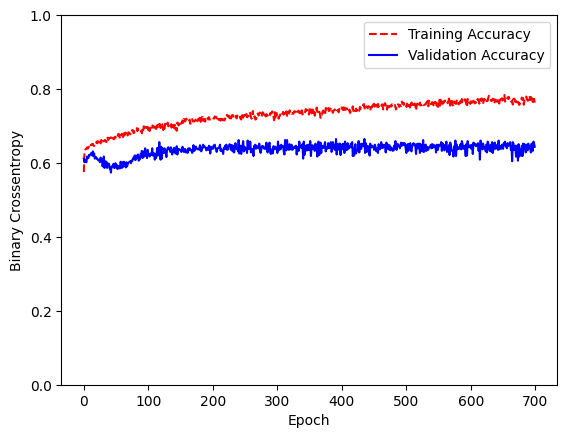

In [49]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [50]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - binary_accuracy: 0.6492 - f1_score: 0.7595 - loss: 0.7480 - precision: 0.6857 - recall: 0.7883
Test accuracy: 64.92%
Test loss: 0.748


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


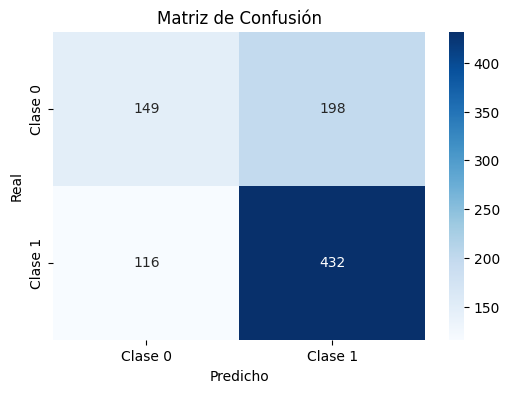

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.56      0.43      0.49       347
     Clase 1       0.69      0.79      0.73       548

    accuracy                           0.65       895
   macro avg       0.62      0.61      0.61       895
weighted avg       0.64      0.65      0.64       895



In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))
